classification of players position

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import URL
from sqlalchemy import text
from urllib.parse import quote_plus
from sqlalchemy.types import Integer, VARCHAR, CHAR
from sqlalchemy import ForeignKeyConstraint
import pandas as pd 
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

Connect to database

In [2]:
url_object = URL.create(
    "mysql+mysqlconnector",
    username="root",
    password="farzansql",
    host="localhost",
)

In [3]:
engine = create_engine(url_object)

In [4]:
with engine.connect() as conn:
    conn.execute(text('USE football;'))
    tables = conn.execute(text('SHOW TABLES;'))
    
    for table in tables.all() : 
        print(table)

('club',)
('coach',)
('coach_season_info',)
('country',)
('league',)
('league_goals',)
('outfitter',)
('player_info',)
('players',)
('players_season_info',)
('positions',)
('season',)
('season_info',)
('stats',)
('transfer',)
('victories',)
('victories_season_info',)


Get data

In [5]:
query = text("""
select t2.player_id, given_name, citizenship, date_of_birth, foot, height, position_name, appearances, 
       goals, asists, yellow_cards,second_yellow_cards, red_cards, minutes_played, goals_conceded, clean_sheets,player_market_value
from(select t.player_id, player_market_value, position_name 
		from (select season_info_id, player_id, player_market_value, position_name
				from players_season_info
				join positions on positions.position_id = players_season_info.position_id) as t
		join season_info on season_info.season_info_id = t.season_info_id 
		where season_id = 7) as t2
join stats on stats.player_id = t2.player_id
join players on players.player_id = t2.player_id
""")

with engine.connect() as conn : 
    conn.execute(text('USE football'))
    players_data = pd.read_sql(query, conn)
    
players_data.drop_duplicates(inplace=True)

Data preprocessing

In [6]:
def to_age(date):
    if date is not None:
        try:
            birth_date = datetime.strptime(date, '%b %d, %Y')
        except ValueError:
            birth_date = datetime.strptime(date, '%d-%b-%y')
        age = (datetime.now() - birth_date).days // 365
        return age
    else:
        return np.nan

players_data['date_of_birth']=players_data['date_of_birth'].apply(to_age)
players_data.head(5)

,player_id,given_name,citizenship,date_of_birth,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,minutes_played,goals_conceded,clean_sheets,player_market_value
0,238223,Ederson,Brazil,29,left,188.0,Goalkeeper,49.0,-,None,4,-,-,4.423',40.0,25.0,€45.00m
1,221624,Zack Steffen,United States,28,right,191.0,Goalkeeper,9.0,-,None,1,-,-,810',10.0,2,€6.00m
2,14555,Scott Carson,England,37,right,188.0,Goalkeeper,1,-,None,-,-,-,17',-,1.0,€300k
3,621997,Cieran Slicker,Scotland,20,None,NaN,Goalkeeper,20,-,None,2,-,-,1.800',34,7,None
4,258004,Rúben Dias,Portugal,26,right,187.0,Centre-Back,40,2,5,6,-,-,3.292',None,None,€75.00m


In [7]:
players_data.isna().sum()

player_id                 0
given_name                0
citizenship               0
date_of_birth             0
foot                    149
height                  143
position_name             0
appearances              22
goals                    22
asists                  461
yellow_cards             22
second_yellow_cards      22
red_cards                22
minutes_played           22
goals_conceded         3234
clean_sheets           3234
player_market_value     198
dtype: int64

In [8]:
players_data = players_data[players_data['appearances'].notna()].reset_index(drop=True)

In [9]:
def right_format(x):
    if x != None:
        x = x.replace("€", "").strip()
        if "m" == x[-1]:
            x = float(x.replace("m", "")) * (10 ** 6)
        elif "k" == x[-1]:
            x = float(x.replace("k", "")) * (10 ** 3)
        elif "b" == x[-1]:
            x = float(x.replace("b", "")) * (10 ** 9)            
        return x
    
players_data['player_market_value'] = players_data['player_market_value'].apply(right_format)
players_data.head(4)

,player_id,given_name,citizenship,date_of_birth,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,minutes_played,goals_conceded,clean_sheets,player_market_value
0,238223,Ederson,Brazil,29,left,188.0,Goalkeeper,49.0,-,None,4,-,-,4.423',40.0,25.0,45000000.0
1,221624,Zack Steffen,United States,28,right,191.0,Goalkeeper,9.0,-,None,1,-,-,810',10.0,2,6000000.0
2,14555,Scott Carson,England,37,right,188.0,Goalkeeper,1,-,None,-,-,-,17',-,1.0,300000.0
3,621997,Cieran Slicker,Scotland,20,None,NaN,Goalkeeper,20,-,None,2,-,-,1.800',34,7,NaN


In [10]:
players_data['minutes_played'] = players_data['minutes_played'].apply(lambda x: x.replace("\'", '').replace(".", ''))

players_data["foot"] = players_data["foot"].fillna('right')

median = players_data["height"].median()
players_data["height"] = players_data["height"].fillna(median)

median = players_data["player_market_value"].median()
players_data["player_market_value"] = players_data["player_market_value"].fillna(median)

players_data = players_data.replace({'-': '0'})
players_data.fillna('0', inplace=True)
players_data.head(3)

,player_id,given_name,citizenship,date_of_birth,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,minutes_played,goals_conceded,clean_sheets,player_market_value
0,238223,Ederson,Brazil,29,left,188.0,Goalkeeper,49.0,0,0,4,0,0,4423,40.0,25.0,45000000.0
1,221624,Zack Steffen,United States,28,right,191.0,Goalkeeper,9.0,0,0,1,0,0,810,10.0,2,6000000.0
2,14555,Scott Carson,England,37,right,188.0,Goalkeeper,1,0,0,0,0,0,17,0,1.0,300000.0


In [11]:
cols = ['date_of_birth', 'height', 'appearances', 'goals', 'asists', 'yellow_cards',
        'second_yellow_cards', 'red_cards', 'minutes_played', 'goals_conceded', 'clean_sheets']

players_data[cols]=players_data[cols].astype('float').astype('int')
players_data['player_market_value']=players_data['player_market_value'].astype('float')

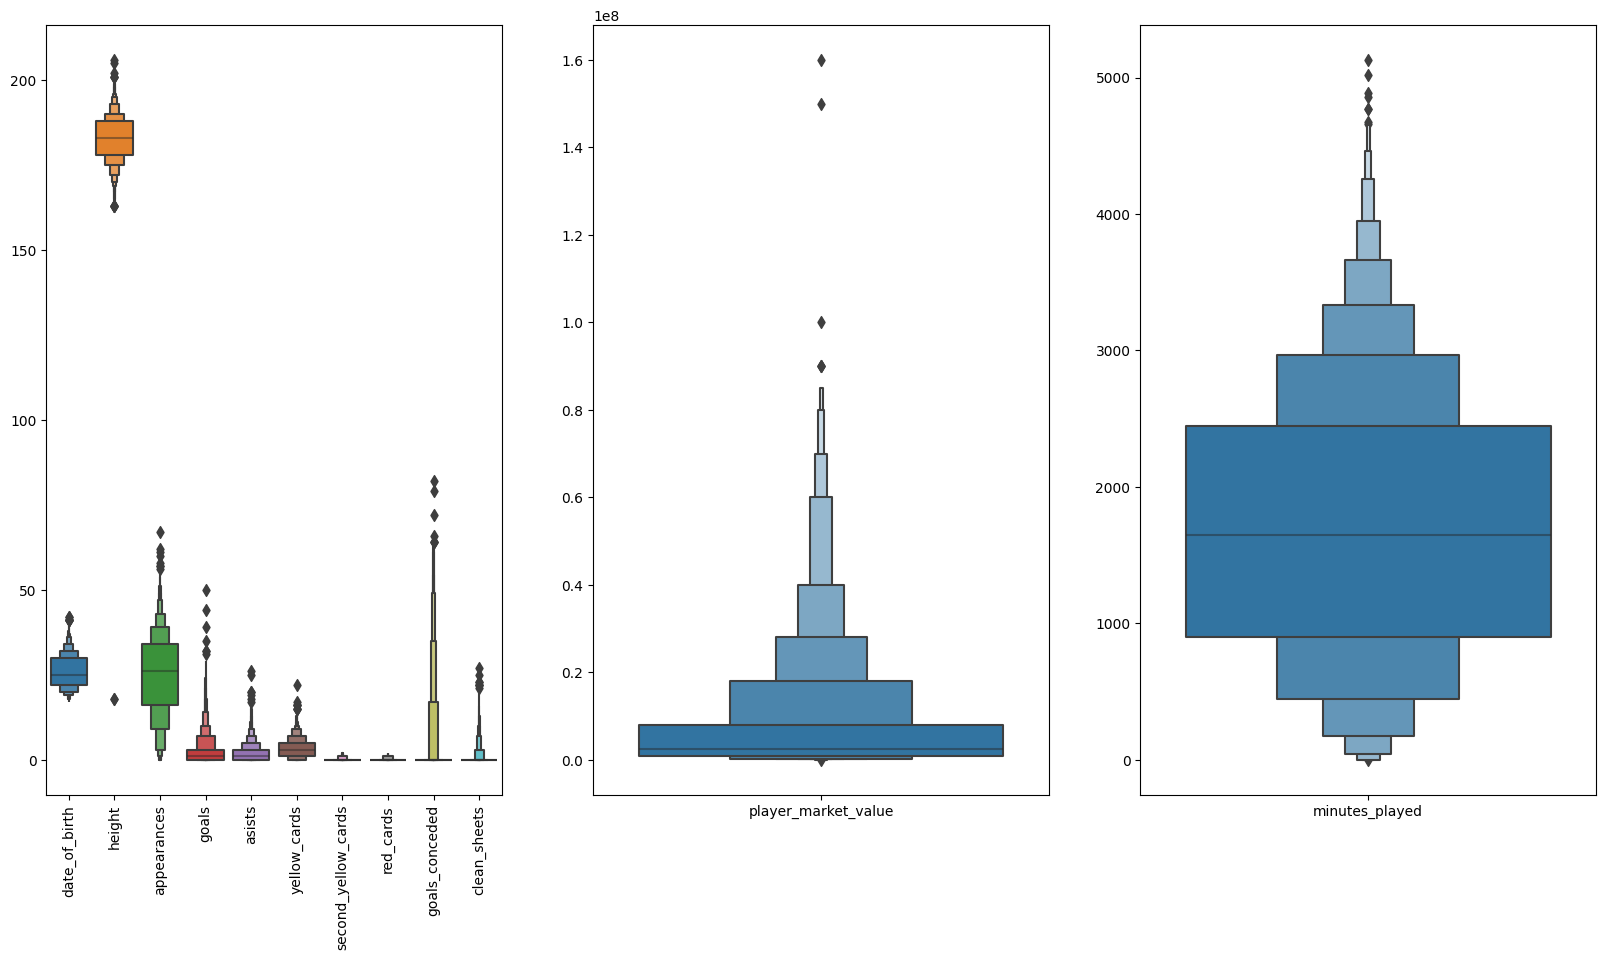

In [12]:
fig, axes = plt.subplots(ncols=3,figsize = (20, 10))
sns.boxenplot(players_data[cols].drop('minutes_played', axis=1), ax = axes[0])
sns.boxenplot(players_data[['player_market_value']], ax=axes[1])
sns.boxenplot(players_data[['minutes_played']], ax=axes[2])
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
plt.show()

<Axes: >

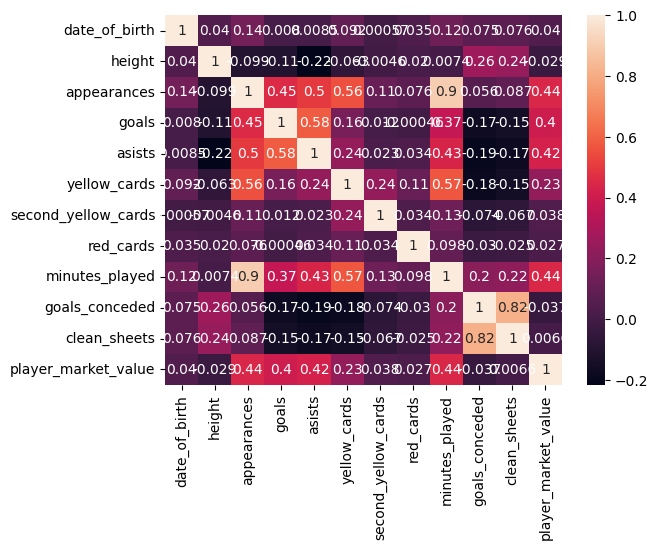

In [13]:
sns.heatmap(players_data[cols+['player_market_value']].corr(), annot=True)

In [14]:
players_data["goal_contribution"] = (players_data["goals"] + players_data["asists"]) / players_data["minutes_played"]
players_data["goal_contribution"] = players_data["goal_contribution"].fillna(0)
players_data["goal_difference"] = players_data["goals"] - players_data["goals_conceded"]

In [15]:
players_data = players_data.drop(['player_id', 'given_name', 'minutes_played'], axis=1)
X_train = players_data.drop(columns=['position_name'])
y_train = players_data['position_name']

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

idx2label = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
print(idx2label)

{0: 'Attack', 1: 'Attacking Midfield', 2: 'Central Midfield', 3: 'Centre-Back', 4: 'Centre-Forward', 5: 'Defensive Midfield', 6: 'Goalkeeper', 7: 'Left Midfield', 8: 'Left Winger', 9: 'Left-Back', 10: 'Right Midfield', 11: 'Right Winger', 12: 'Right-Back', 13: 'Second Striker', 14: 'midfield'}


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=31)

In [18]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = X_train.select_dtypes(include = "object").columns

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[categorical_cols] = enc.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = enc.transform(X_test[categorical_cols])

In [19]:
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=np.number).columns

std_scaler = StandardScaler()
X_train.loc[:, num_cols] = std_scaler.fit_transform(X_train.loc[:, num_cols])
X_test.loc[:, num_cols] = std_scaler.transform(X_test.loc[:, num_cols])

X_test.head(2)

,citizenship,date_of_birth,foot,height,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,goals_conceded,clean_sheets,player_market_value,goal_contribution,goal_difference
3091,1.304764,-0.995600,0.602606,-0.605265,0.468006,-0.162488,-0.360102,1.176615,-0.271118,-0.295358,-0.266825,-0.240515,-0.540719,-0.457988,0.168309
2395,-0.572733,-0.387748,0.602606,0.284972,2.491844,0.534572,4.468400,1.837266,-0.271118,-0.295358,-0.266825,-0.240515,1.325084,0.489714,0.434012


RandomForest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5403556771545828
